In [125]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [126]:
def initQTable(gameEnvironment):
    return np.zeros((gameEnvironment.observation_space.n, gameEnvironment.action_space.n))

In [127]:
def chooseAction(gameEnvironment, state, QTable, epsilon):
    if np.random.uniform() < epsilon:
        action = gameEnvironment.action_space.sample()
    else:
        action = np.argmax(QTable[state, :])
    return action

In [128]:
def getUpdatedQTable(currentState, nextState, action, reward, QTable, beta, gamma):
    QTable[currentState, action] = QTable[currentState, action] + beta * (reward + gamma * np.max(QTable[nextState, :]) - QTable[currentState, action])
    return QTable

In [227]:
def playGame(gameEnvironment, QTable, maxSteps):
    currentState = gameEnvironment.reset()[0]
    isEndState = False
    totalReward = 0
    step = 0
    while not isEndState and step < maxSteps:
        action = chooseAction(gameEnvironment, currentState, QTable, 0)
        nextState, reward, isEndState, _,_ = gameEnvironment.step(action)
        currentState = nextState
        totalReward += reward
        step += 1
        
    return totalReward

- gamma - dyskont (0;1) - im bliższy 1 tym większą wagę mają odległe w czasie nagrody
- beta - szybkość uczenia (z czasem zmniejszana)

In [129]:
def QLearning(gameEnvironment, maxEpisodes, maxT, gamma, beta, epsilon):
    if epsilon > 1 or epsilon < 0:
        raise ValueError("Epsilon must be between 0 and 1")
    if beta > 1 or beta < 0:
        raise ValueError("Beta must be between 0 and 1")
    if gamma < 0:
        raise ValueError("Gamma must be greater than 0")
    QTable = initQTable(gameEnvironment)
    episode=0
    episodeRewards = []
    while episode < maxEpisodes:
        currentState = gameEnvironment.reset()[0]
        episodeRewards.append(0)
        t = 0
        while t < maxT:
            action = chooseAction(gameEnvironment, currentState, QTable, epsilon)
            nextState, reward, isEndState, _, _= gameEnvironment.step(action)
            episodeRewards[episode] += reward

            QTable = getUpdatedQTable(currentState,nextState, action, reward, QTable, beta, gamma)
            currentState = nextState
            if isEndState:
                break
            t+=1
        episode+=1
    return QTable, episodeRewards

In [402]:
def getMeanRewards(episodeRewards, windowSize):
    meanRewards = []
    for i in range(len(episodeRewards)//windowSize):
        meanRewards.append(np.mean(episodeRewards[max(0,i*windowSize):min(len(episodeRewards)-1,(i+1)*windowSize)]))
    return np.array(meanRewards)

In [403]:
def plotMeanRewards(episodeRewards, episodes, windowSize):
    plt.plot(np.linspace(0,episodes,windowSize),episodeRewards)
    plt.title(f'Mean Reward per {windowSize} episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

In [432]:
def getMeanRewardsForMultipleRuns(gameEnvironment, maxEpisodes, maxT, gamma, beta, epsilon, runs, windowSize):
    meanRewards = np.zeros(maxEpisodes//windowSize) 
    lastTableGame = 0
    for i in range(runs):
        QTable, episodeRewards = QLearning(gameEnvironment, maxEpisodes, maxT, gamma, beta, epsilon)
        meanRewards += getMeanRewards(episodeRewards, windowSize)
        lastTableGame += playGame(gameEnvironment, QTable, maxT)
    return meanRewards/(runs), lastTableGame/runs

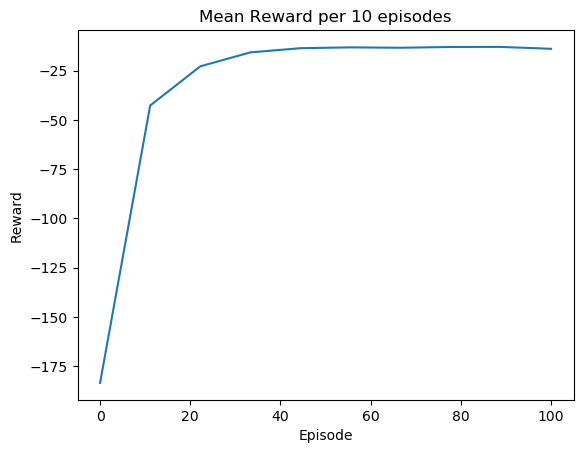

In [453]:
gameEnvironment = gym.make('CliffWalking-v0')
maxEpisodes = 100
maxT = 100
beta = 0.9
gamma = 1
epsilon = 0.001

QTable, episodeRewards = QLearning(gameEnvironment, maxEpisodes, maxT, gamma, beta, epsilon)
windowSize = 10
meanRewards, lastGame = getMeanRewardsForMultipleRuns(gameEnvironment, maxEpisodes, maxT, gamma, beta, epsilon, 50, windowSize)
plotMeanRewards(meanRewards, maxEpisodes, windowSize)

# Badanie wpływu parametrów beta i gamma na jakość działania algorytmu

| gamma  | beta | 0-10   | 11-20  | 21-30  | 31-40  | 41-50  | 51-60  | 61-70  | 71-80  | 81-90  | 91-100 | ostateczny wynik |
|--------|------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|------------------|
| 1      | 0.1  | -200.716 | -92.82  | -88.896 | -80.398 | -73.35  | -65.654 | -60.246 | -54.552 | -48.712 | -46.31111111 | -100.0 |
| 1      | 0.2  | -196.902 | -88.504 | -69.836 | -57.19  | -48.818 | -40.366 | -35.496 | -31.454 | -28.852 | -26.02666667 | -88.02 |
| 1      | 0.4  | -194.934 | -67.176 | -45.974 | -34.178 | -28.59  | -23.404 | -20.248 | -16.784 | -14.388 | -13.91555556 | -13.0 |
| 1      | 0.7  | -186.584 | -47.906 | -28.696 | -21.916 | -16.646 | -13.272 | -13.474 | -13.648 | -13.214 | -13.02222222 | -13.0 |
| 1      | 0.9  | -183.762 | -43.78  | -21.848 | -16.158 | -13.422 | -13.034 | -14.27  | -13.23  | -13.44  | -13.00666667 | -13.0 |
| 0.1    | 0.9  | -194.45  | -53.55  | -28.392 | -17.456 | -13.248 | -13.212 | -13.448 | -13.012 | -13.006 | -13.70888889 | -13.0 |
| 0.01   | 0.9  | -201.752 | -79.67  | -99.794 | -99.966 | -99.756 | -99.75  | -100.   | -99.822 | -99.914 | -99.79111111 | -100.0 |
| 0.05   | 0.9  | -199.276 | -62.71  | -30.192 | -20.326 | -13.458 | -13.222 | -13.874 | -13.416 | -13.024 | -13.03111111 | -13.0 |
| 0.5    | 0.9  | -183.216 | -42.772 | -24.688 | -17.362 | -13.214 | -13.232 | -13.232 | -13.242 | -13.208 | -13.49555556 | -13.0 |
| 5      | 0.9  | -272.22  | -135.798| -61.48  | -15.872 | -13.038 | -13.014 | -13.008 | -13.442 | -13.442 | -13.73111111 | -13.0 |
| 10     | 0.9  | -300.588 | -146.528| -45.248 | -13.498 | -13.02  | -13.224 | -14.08  | -13.858 | -13.442 | -13.73555556 | -13.0 |
| 100    | 0.9  | -297.876 | -150.664| -53.392 | -13.95  | -13.406 | -13.218 | -13.886 | -13.048 | -13.042 | -13.25111111 | -13.0 |
| 100000 | 0.9  | -287.02  | -143.634| -70.452 | -13.538 | -13.648 | -13.232 | -13.216 | -13.212 | -13.016 | -13.73111111 | -13.0 |
